## Import Packages

In [29]:
#removing warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    

# Data loading
import pymongo
from pymongo import MongoClient

# Data transformation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, date
import time

# Scipy statistics
from scipy.stats import shapiro
from scipy.stats import chi2_contingency


# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno

## visualisation config
from matplotlib import colors
from matplotlib.colors import ListedColormap
%matplotlib inline
sns.set_palette("Greens_d")

# Insteractive shells
from IPython.display import display

# ML Tools
from yellowbrick.cluster import KElbowVisualizer
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score

# 1. Loading Data

In [2]:
# instantiate mongodb cluster object
cluster = MongoClient("mongodb+srv://lliebenberg93:<PASSWORD>.psf7kxf.mongodb.net/?retryWrites=true&w=majority") 
# database
db = cluster["sales_demo"]
# collections
customer_information = db.customer_information
sales = db.sales
agent_info = db.agent_info

### Converting data to dataframes

In [3]:
# convert collections to pandas dataframes
df_customer_information = pd.DataFrame(list(customer_information.find()))
df_sales = pd.DataFrame(list(sales.find()))
df_agent_info = pd.DataFrame(list(agent_info.find()))
df_agent_info = df_agent_info[['agent_code','agent_name']]

In [4]:
df_customer_information.info()
df_sales.info()
df_agent_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   _id            10000 non-null  object
 1   contract_key   10000 non-null  int64 
 2   date_of_birth  10000 non-null  object
 3   nett_salary    10000 non-null  int64 
 4   gender         10000 non-null  object
 5   province       10000 non-null  object
 6   language       10000 non-null  object
 7   phone          10000 non-null  object
 8   agent_code     10000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 703.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           5000 non-null   object
 1   contract_key  5000 non-null   int64 
 2   segment       5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


## Joining dataframes. Parent table is customer information since we want applications and activations. 

In [5]:
customer_info_activations = pd.merge(df_sales,df_customer_information,on='contract_key',how="left") # Left Joining activations & Customer information
df = pd.merge(customer_info_activations,df_agent_info, on = "agent_code", how = "left") # Inner Join above result to agent_info table to get agent names

> Let's take a peak at what our dataframe looks like...

# 2. Feature Engineering 

In [6]:
# Extracting age from date of birth in customer information table
def age(born):
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], format='%Y-%m-%d')                                         
df['age'] = df['date_of_birth'].apply(age)

# 3. Data Preproccessing

> Let us address some of the missing values and other inconsistencies

In [7]:
# standardize columns
df['gender'] = df['gender'].str.lower()
df['province'] = df['province'].str.lower()
df['language'] = df['language'].str.lower()

# 4. Feature Selection

### Correlation Analysis
> Only on numerical features age and nett_salary

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

<Axes: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

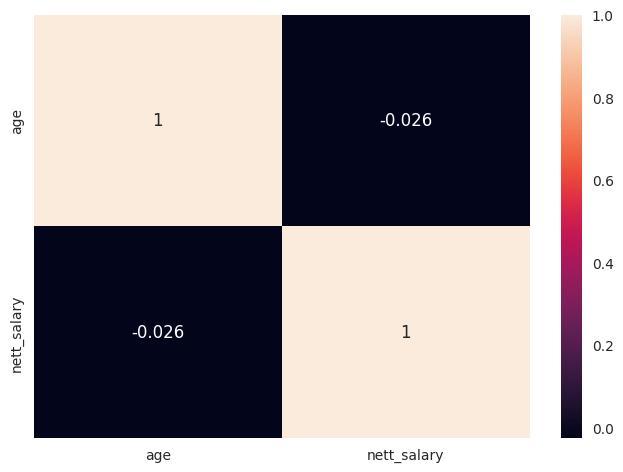

In [8]:
numerical = df[['age','nett_salary']]

# Calculate the correlation matrix
corr_matrix = numerical.corr()
# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix, annot=True)

> Age and nett_salary have a weak negative correlation. Not what you would normally expect, since in general the older you are the more likely you are to be making more money. But once again this is randomly generated data.

### Chi-square test of independence
> Only on nominal features, 

In [9]:
nominal_df = df[['gender','language','province']]

cont_table = pd.crosstab(nominal_df['gender'], [nominal_df['language'], nominal_df['province']])

# Perform the chi-squared test
chi2, p_value, dof, expected = chi2_contingency(cont_table)

# Print the results
print("Chi-square statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)


Chi-square statistic: 44.213857829600435
P-value: 0.4626042732819425
Degrees of freedom: 44
Expected frequencies: [[58.6696 58.6696 63.1444 57.178  50.2172 53.6976 58.1724 50.7144 53.6976
  52.206  54.692  58.6696 46.7368 57.6752 60.1612 43.2564 54.692  61.1556
  60.6584 58.6696 52.206  62.15   59.1668 47.7312 56.6808 52.7032 51.7088
  59.664  53.2004 51.2116 52.7032 52.206  61.1556 51.7088 60.1612 57.6752
  59.664  51.7088 54.692  63.6416 60.6584 54.692  49.72   55.6864 40.7704]
 [59.3304 59.3304 63.8556 57.822  50.7828 54.3024 58.8276 51.2856 54.3024
  52.794  55.308  59.3304 47.2632 58.3248 60.8388 43.7436 55.308  61.8444
  61.3416 59.3304 52.794  62.85   59.8332 48.2688 57.3192 53.2968 52.2912
  60.336  53.7996 51.7884 53.2968 52.794  61.8444 52.2912 60.8388 58.3248
  60.336  52.2912 55.308  64.3584 61.3416 55.308  50.28   56.3136 41.2296]]


> Walking through the results above, the chi-square statistic of 44 implies that the nominal variables are dependent. The p-value suggests that there is not sufficient evidence to reject the null hypothesis, and we cannot conclude that the two variables are associated.

# 3. EDA

### Missing Values 

<Axes: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

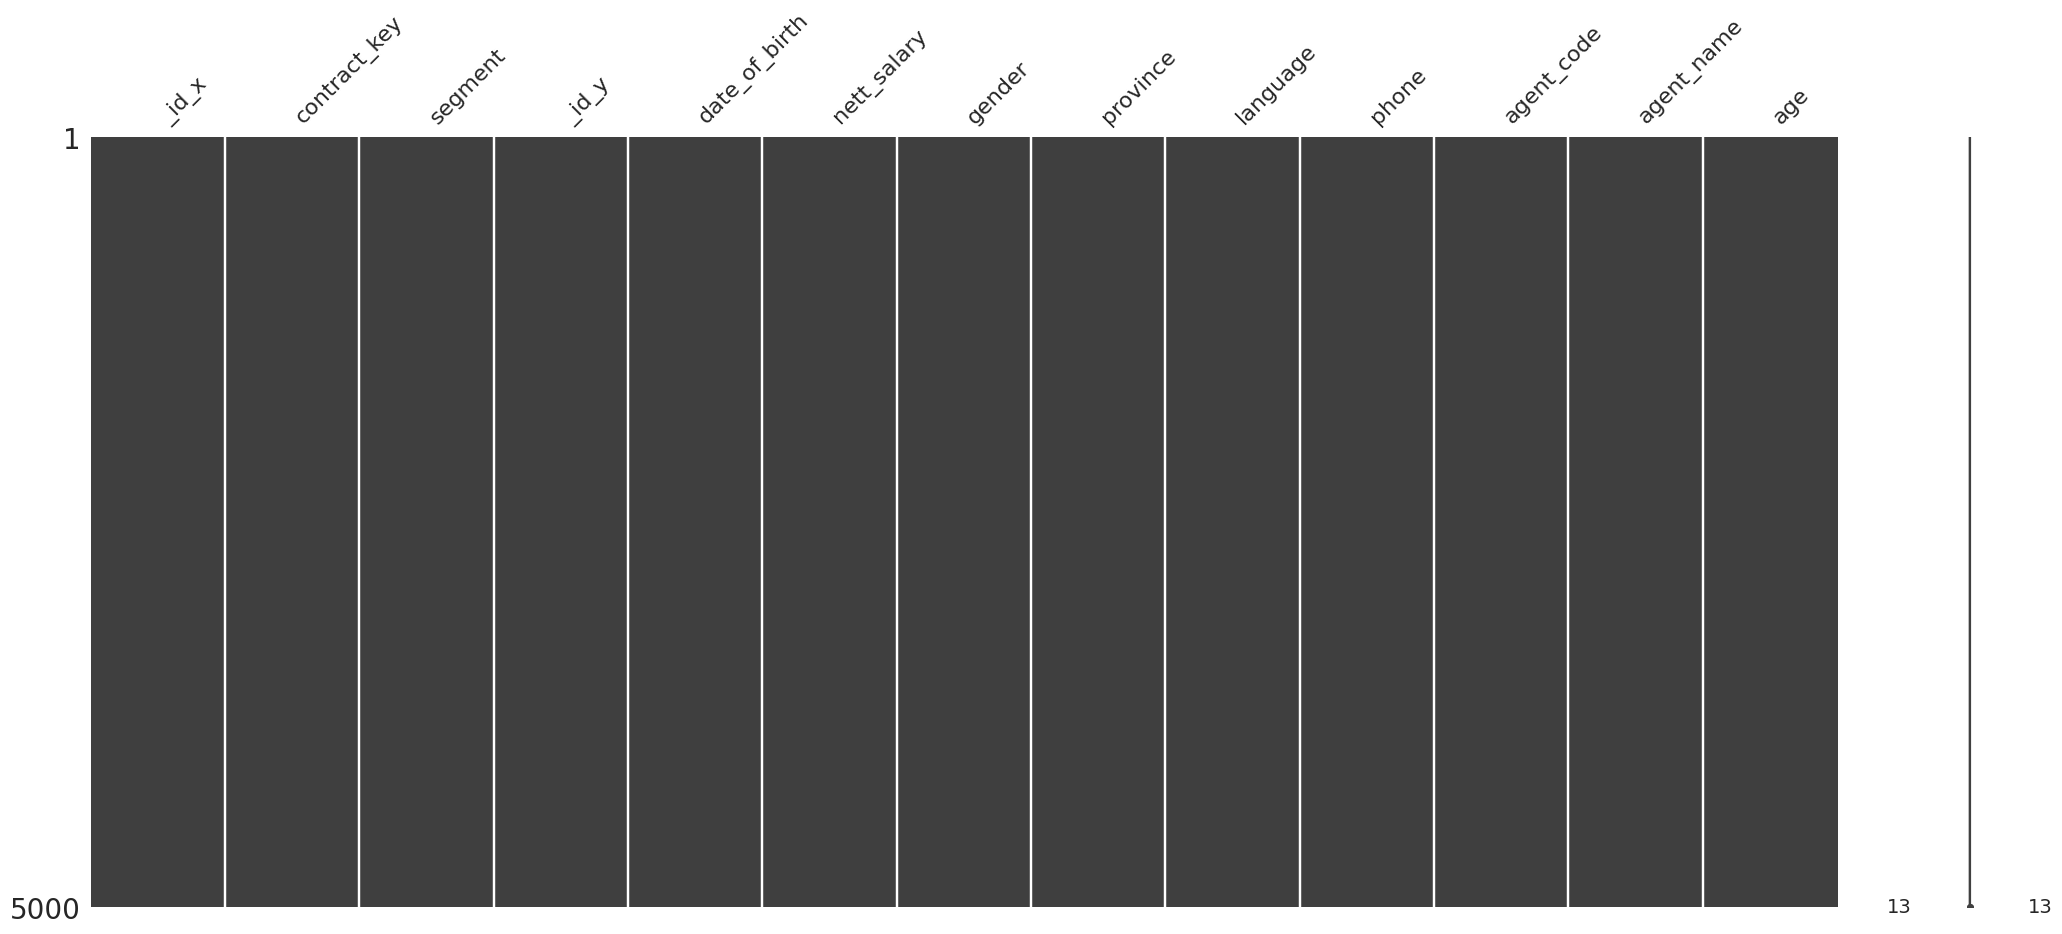

In [10]:
msno.matrix(df)

> We can see that no columns have missing values. In reality you would have a lot more missing data and there are a couple of strategies to address this. For example, if nett_salary had missing values, you could build a lightweight logistic regression model that predicts the income based on age and whatever other numerical features you have).

### Distributions of numerical features
> Lets look at distributions for the numerical features and spot any outliers that could bias our algorithm.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

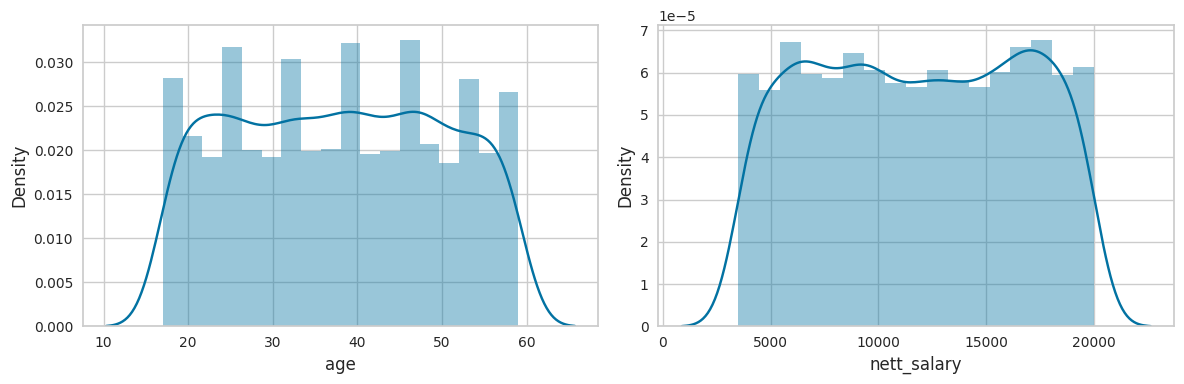

In [12]:
def distributions(df):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    sns.distplot(df["age"], ax=ax1)
    sns.distplot(df["nett_salary"], ax=ax2)
    plt.tight_layout()
distributions(df)

> Important to note is the shape of the distribution curve. Age and nett_salary are clearly uniformely distributed. We will need to keep in mind though that if we use a K-means algorithm (which is a centroid-based clustering algorithm): for uniformely distributed data, the data points are evenly spaced so the initial random placement of the centroids can have a significant impact on the final clustering results. We might have to consider alternate algorithms such as K-means++ or hierarchical clusteringto innitialise the centroids.

# 5. Model Selection 

> Since we are 

In [40]:
# Select relevant features
X = df[['nett_salary', 'age', 'gender', 'language', 'province']]


In [41]:
# Encode categorical columns
le = LabelEncoder()
X['gender'] = le.fit_transform(X['gender'])
X['language'] = le.fit_transform(X['language'])
X['province'] = le.fit_transform(X['province'])

In [42]:
# Scale numerical features
scaler = StandardScaler()
X[['nett_salary', 'age']] = scaler.fit_transform(X[['nett_salary', 'age']])

In [46]:
# Find optimal number of clusters
silhouette_scores = []
for k in range(3, 7):
    kproto = KPrototypes(n_clusters=k, init='Cao', n_init=2, verbose=4)
    clusters = kproto.fit_predict(X.values, categorical=[2, 3, 4])
    silhouette_scores.append(silhouette_score(X.values, clusters))

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1037, ncost: 9342.710961460756
Run: 1, iteration: 2/100, moves: 373, ncost: 9258.736967572375
Run: 1, iteration: 3/100, moves: 98, ncost: 9255.550005836978
Run: 1, iteration: 4/100, moves: 33, ncost: 9254.775198687646
Run: 1, iteration: 5/100, moves: 25, ncost: 9253.96862661448
Run: 1, iteration: 6/100, moves: 38, ncost: 9252.60163776271
Run: 1, iteration: 7/100, moves: 23, ncost: 9252.145337373444
Run: 1, iteration: 8/100, moves: 11, ncost: 9251.954955615629
Run: 1, iteration: 9/100, moves: 13, ncost: 9251.773518444574
Run: 1, iteration: 10/100, moves: 8, ncost: 9251.678094491343
Run: 1, iteration: 11/100, moves: 12, ncost: 9251.52294826064
Run: 1, iteration: 12/100, moves: 22, ncost: 9250.990735492851
Run: 1, iteration: 13/100, moves: 19, ncost: 9250.5578555008
Run: 1, iteration: 14/100, moves: 10,

In [47]:
# Choose the number of clusters with the highest silhouette score
best_k = silhouette_scores.index(max(silhouette_scores)) + 2
print("Best number of clusters:", best_k)

Best number of clusters: 2


In [48]:
# Fit K-Prototypes with best k
kproto = KPrototypes(n_clusters=2, init='Cao', n_init=1, verbose=2)
clusters = kproto.fit_predict(X.values, categorical=[2, 3, 4])

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 724, ncost: 11650.048757563634
Run: 1, iteration: 2/100, moves: 249, ncost: 11589.149084879971
Run: 1, iteration: 3/100, moves: 147, ncost: 11556.21656195632
Run: 1, iteration: 4/100, moves: 33, ncost: 11555.59058717372
Run: 1, iteration: 5/100, moves: 18, ncost: 11555.261063089785
Run: 1, iteration: 6/100, moves: 7, ncost: 11555.20193241979
Run: 1, iteration: 7/100, moves: 4, ncost: 11555.186986756566
Run: 1, iteration: 8/100, moves: 2, ncost: 11555.17803828542
Run: 1, iteration: 9/100, moves: 3, ncost: 11555.157925207146
Run: 1, iteration: 10/100, moves: 3, ncost: 11555.146319628975
Run: 1, iteration: 11/100, moves: 0, ncost: 11555.146319628975


In [49]:
# Add cluster labels to original dataframe
df['cluster'] = clusters

In [51]:
df.loc[df['cluster']==1]

,contract_key,nett_salary,gender,province,language,agent_name,age,cluster
6,48328,9989,female,mp,xhosa,Prince,39,1
7,92914,6366,female,nc,zulu,Tanita,57,1
10,94294,9979,male,kzn,afrikaans,Xolani,26,1
11,95630,9173,male,mp,english,Tanita,33,1
13,96853,6358,female,ec,sesotho,Xolani,43,1
...,...,...,...,...,...,...,...,...
4991,28884,9196,male,lp,english,Prince,21,1
4994,75742,4780,male,lp,english,Asanda,33,1
4995,74416,5689,male,nw,zulu,Ariel,21,1
4996,81203,9041,female,mp,xhosa,Xolani,50,1


In [52]:
# Calculate cluster proportions for each agent_name
agent_cluster_counts = df.groupby(['agent_name', 'cluster']).size().unstack(fill_value=0)
agent_cluster_proportions = agent_cluster_counts.div(agent_cluster_counts.sum(axis=1), axis=0)

In [53]:
# Identify top agents for each cluster
for cluster in range(best_k):
    top_agents = agent_cluster_proportions[cluster].sort_values(ascending=False).head(3)
    print(f"Cluster {cluster}: Top Agents - {list(top_agents.index)}")

Cluster 0: Top Agents - ['Ariel', 'Xolani', 'Tanita']
Cluster 1: Top Agents - ['Prince', 'Asanda', 'Tanita']


> We can use this information to build a data pipeline that distributes leads to these pseudo agents based on which cluster they are more successful in.